# Load libraries

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from hps.predic import high_confidence
from hps.visu import hps_visu
import visu_demo

# Load data

In [3]:
# Grab data from a csv file
data = pd.read_csv('data_toy.csv', index_col=0)

# Format the data
X = data[['x1','x2']].get_values()
y = data['y'].get_values()

# Train model

Stage 1
Stage 2


(array([  9.,   1.,   0.,   0.,   1.,   2.,   2.,   1.,   1.,  63.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

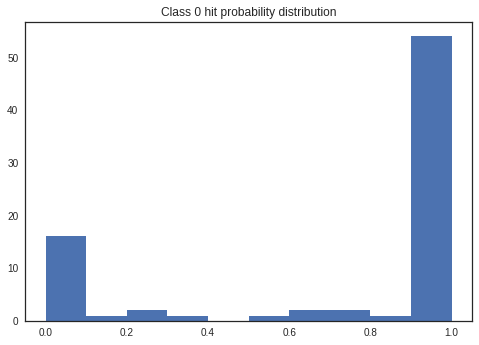

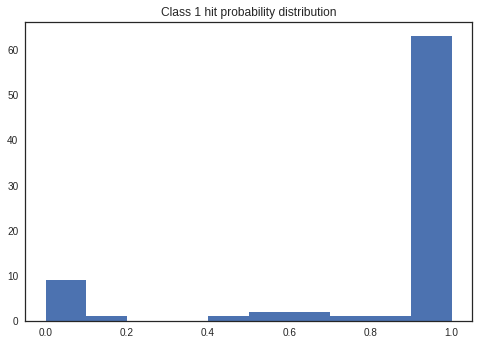

In [17]:
res_hitproba = []

hps = high_confidence.TwoStagesPrediction(verbose=False,
                                          n_iter=1000,
                                          shuffle_test_split=0.5,
                                          min_gamma=1.,
                                          thresh_ratio=0.1)
hps.fit(X,y)
res_hitproba = hps.training_hit_probability

plt.figure()
plt.title('Class 0 hit probability distribution')
plt.hist(hps.training_hit_probability[y==0],10)
plt.figure()
plt.title('Class 1 hit probability distribution')
plt.hist(hps.training_hit_probability[y==1],10)


# View the results

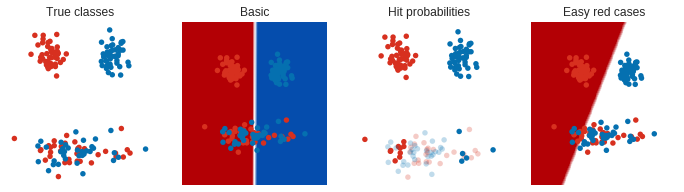

In [21]:
reload(visu_demo)

sns.set_style("white")
fig = plt.figure(figsize=(3*4,3,))
ax1 = fig.add_subplot(1,4,1)
ax1.axis('off')
ax1.set_title("True classes")
visu_demo.scatter_points(X,y,new_fig=False,ax1=ax1)

ax1 = fig.add_subplot(1,4,2)
ax1.axis('off')
ax1.set_title("Basic")
visu_demo.plot_2classes(X,y,hps,show_class=[-1],ax1=ax1)

ax1 = fig.add_subplot(1,4,3)
ax1.axis('off')
ax1.set_title("Hit probabilities")
visu_demo.scatter_points(X,y,new_fig=False,res_hitproba=res_hitproba,ax1=ax1)

ax1 = fig.add_subplot(1,4,4)
ax1.axis('off')
ax1.set_title("Easy red cases")
visu_demo.plot_2classes(X,y,hps,show_class=[1],ax1=ax1)


# Save trained model

In [ ]:
file_name = 'hps_model.pkl'
           
data_results = {'hps': hps}
pickle.dump(data_results, open(file_name, "wb"))

# Cross-validation HPS
#### Run the model in a 10 fold CV, the precision, specificity and sensitivity is estimated across folds

Stage 1
Stage 2
CV fold classifying...
Stage 1
Stage 2
CV fold classifying...
Stage 1
Stage 2
CV fold classifying...
Stage 1 (BASE)
Class 0 Precision: 85.71 Specificity: 87.50 Recall: 75.00 N: 70
Class 1 Precision: 77.78 Specificity: 75.00 Recall: 87.50 N: 90
Total Precision: 81.75 Specificity: 81.25 Recall: 81.25 N: 80
Stage 2 (HPS)
Class 0 Precision: 97.73 Specificity: 98.75 Recall: 53.75 N: 44
Class 1 Precision: 94.00 Specificity: 96.25 Recall: 58.75 N: 50
Total Precision: 95.86 Specificity: 97.50 Recall: 56.25 N: 47


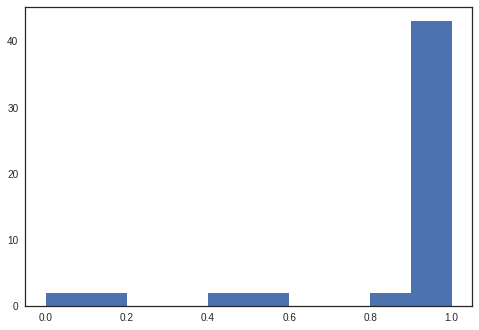

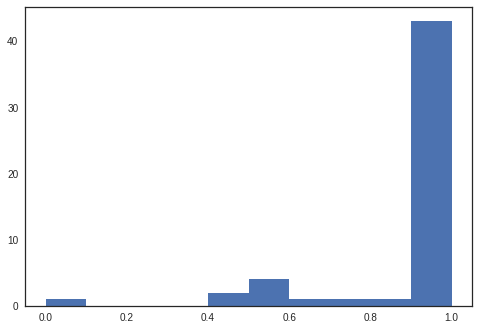

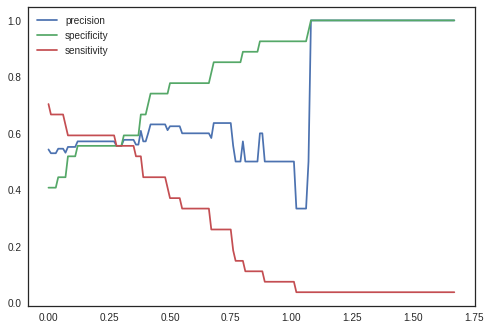

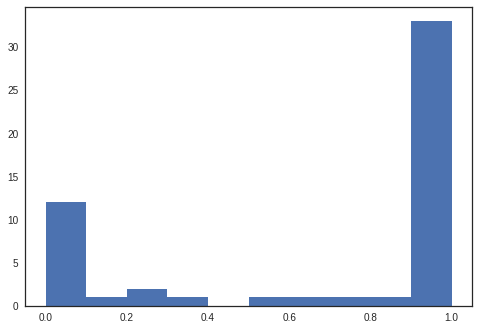

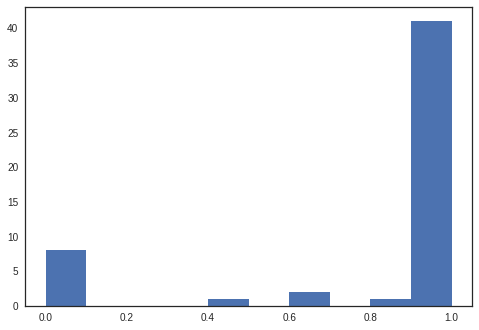

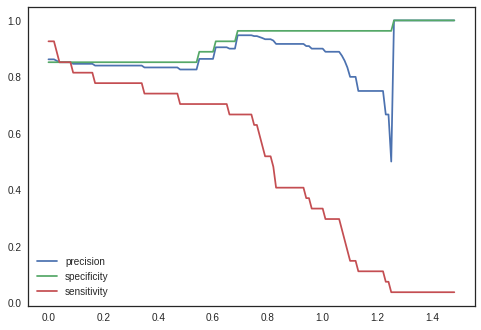

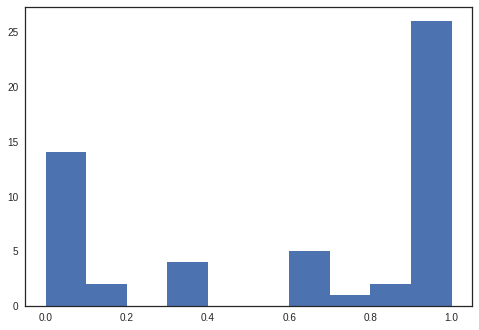

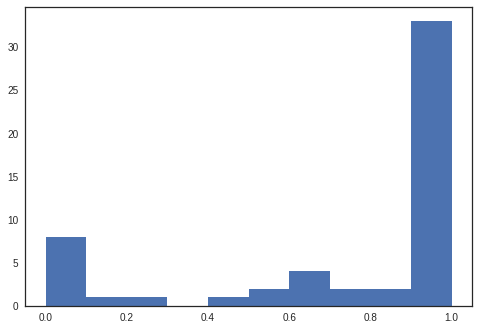

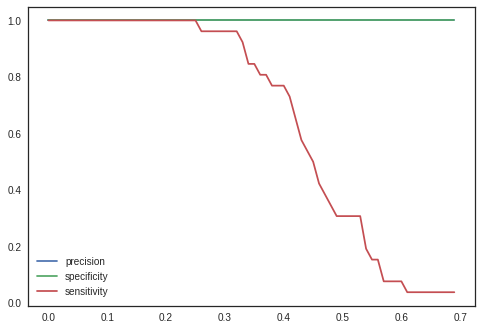

In [16]:
ohe = OneHotEncoder(sparse=False)
ohe.fit(y.reshape(-1, 1))
labels = ohe.transform(y.reshape(-1, 1))

scores_s1=[]
scores_s2 = []
y_target = []

skf = StratifiedKFold(n_splits=3)
for train_index, val_index in skf.split(X,y):
    X_training, X_val = X[train_index], X[val_index]
    y_training, y_val = y[train_index], y[val_index]
    
    
    hps = high_confidence.TwoStagesPrediction(verbose=False,
                                          n_iter=1000,
                                          shuffle_test_split=0.5,
                                          min_gamma=1.,
                                          thresh_ratio=0.1)
    
    hps.fit(X_training, y_training)
    
    scores, dic_results = hps.predict(X_val)
    
    # Test in validation sample
    acc = metrics.accuracy_score(y_val, (dic_results['s1_df'][:,0]>0).astype(float))
    tmp_mask = (dic_results['s2_hat'][:,1]>0) & (dic_results['s1_df'][:,0]>0)
    acc_s2 = metrics.accuracy_score(y_val, (dic_results['s2_df'][:,1]>0).astype(float))
    
    scores_s1.append(dic_results['s1_hat'])
    scores_s2.append(dic_results['s2_hat'])
    
    print('CV fold classifying...')
    
    plt.figure()
    plt.hist(hps.training_hit_probability[y_training==0],10)
    plt.figure()
    plt.hist(hps.training_hit_probability[y_training==1],10)
    
    y_target.append(y_val)
     

scores_s1 = np.vstack(scores_s1)
scores_s2 = np.vstack(scores_s2)
y_target = np.hstack(y_target)

print('##########################')
# S1
y_mb = ohe.transform(y_target[:,np.newaxis])
pred_y_ = scores_s1

print('Stage 1 (BASE)')
hps_visu.print_scores(hps_visu.scores(y_mb, pred_y_))


# S2
y_mb = ohe.transform(y_target[:,np.newaxis])
pred_y_ = scores_s2

print('Stage 2 (HPS)')
hps_visu.print_scores(hps_visu.scores(y_mb, pred_y_)) 
print('##########################')
